In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree


In [3]:
df = pd.read_csv("climatewins_ex2_2_cleaned_unscaled.csv")
print("df shape:", df.shape)
df.head()



df shape: (22950, 186)


,DATE,MONTH,BASEL_cloud_cover,BASEL_wind_speed,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_snow_depth,BASEL_sunshine,...,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,19600101,1,7,2.1,0.85,1.018,0.32,0.09,0,0.7,...,0,0,0,0,0,0,0,0,0,0
1,19600102,1,6,2.1,0.84,1.018,0.36,1.05,0,1.1,...,0,0,0,0,0,0,0,0,0,0
2,19600103,1,8,2.1,0.90,1.018,0.18,0.30,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,19600104,1,3,2.1,0.92,1.018,0.58,0.00,0,4.1,...,0,0,0,0,0,0,0,0,0,0
4,19600105,1,6,2.1,0.95,1.018,0.65,0.14,0,5.4,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Create pleasant day target
# Rule (standard ClimateWins):
# Pleasant = temp_mean between 15–25 AND no precipitation

df["pleasant"] = (
    (df.filter(like="_temp_mean").mean(axis=1).between(15, 25)) &
    (df.filter(like="_precipitation").mean(axis=1) == 0)
).astype(int)

# Check distribution
print(df["pleasant"].value_counts())


pleasant
0    22905
1       45
Name: count, dtype: int64


In [8]:
y_all = df["pleasant"].copy()

X_all = df.drop(columns=["pleasant", "DATE", "MONTH"], errors="ignore").copy()

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)
print("Pleasant rate:", y_all.mean())


X_all shape: (22950, 184)
y_all shape: (22950,)
Pleasant rate: 0.00196078431372549


In [9]:

year = (df["DATE"] // 10000).astype(int)

start_year, end_year = 2000, 2010
decade_mask = (year >= start_year) & (year <= end_year)

X_decade = X_all.loc[decade_mask].copy()
y_decade = y_all.loc[decade_mask].copy()

print("X_decade:", X_decade.shape)
print("y_decade:", y_decade.shape)
print("Decade pleasant rate:", y_decade.mean())


X_decade: (4018, 184)
y_decade: (4018,)
Decade pleasant rate: 0.001991040318566451


In [10]:
basel_cols = [c for c in X_all.columns if c.startswith("BASEL_")]
X_basel = X_all[basel_cols].copy()
y_basel = y_all.copy()

print("BASEL cols:", len(basel_cols))
print("X_basel:", X_basel.shape)
print("y_basel:", y_basel.shape)
print("BASEL pleasant rate:", y_basel.mean())


BASEL cols: 12
X_basel: (22950, 12)
y_basel: (22950,)
BASEL pleasant rate: 0.00196078431372549


In [11]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import time

param_dist_small = {
    "n_estimators": randint(100, 400),
    "max_depth": [None, 5, 10, 20, 30],
    "max_features": randint(1, 10),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "criterion": ["gini", "entropy"]
}


In [12]:
def run_rf_search_and_save_tree(X, y, label, png_name, n_iter=20):
    # Try stratify (helps when target is imbalanced). If it errors, remove stratify.
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

    clf = RandomForestClassifier(random_state=42, n_jobs=-1)

    search = RandomizedSearchCV(
        clf,
        param_distributions=param_dist_small,
        n_iter=n_iter,
        cv=3,
        scoring="accuracy",
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    start = time.time()
    search.fit(X_train, y_train)
    elapsed = (time.time() - start) / 60

    best_model = search.best_estimator_

    print("\n" + "="*70)
    print(label)
    print("Time (min):", round(elapsed, 2))
    print("Best params:", search.best_params_)
    print("Best CV accuracy:", search.best_score_)
    print("Test accuracy:", best_model.score(X_test, y_test))
    print("="*70 + "\n")

    # Save one tree figure
    plt.figure(figsize=(20, 10))
    plot_tree(best_model.estimators_[0], max_depth=3, filled=True, fontsize=8)
    plt.title(f"Optimized RF Tree — {label}")
    plt.savefig(png_name, dpi=200, bbox_inches="tight")
    plt.show()

    return search, best_model


Fitting 3 folds for each of 20 candidates, totalling 60 fits

All Stations (Decade)
Time (min): 0.38
Best params: {'criterion': 'gini', 'max_depth': 20, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 202}
Best CV accuracy: 0.9981331670313233
Test accuracy: 0.9975124378109452



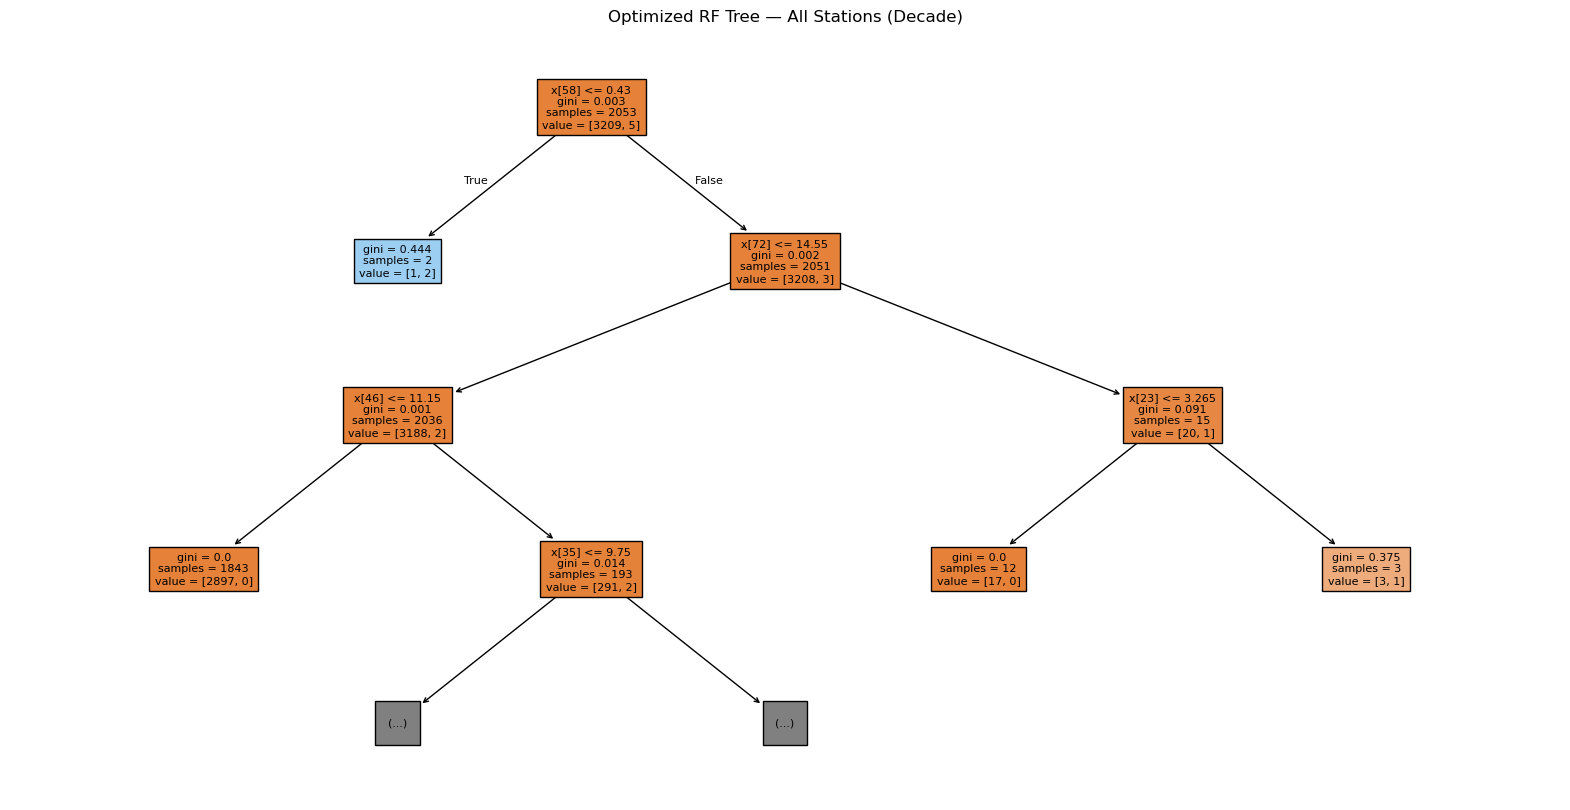

Fitting 3 folds for each of 20 candidates, totalling 60 fits

BASEL (Full Timeline)
Time (min): 0.56
Best params: {'criterion': 'gini', 'max_depth': 20, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 202}
Best CV accuracy: 0.9980392156862745
Test accuracy: 0.9980392156862745



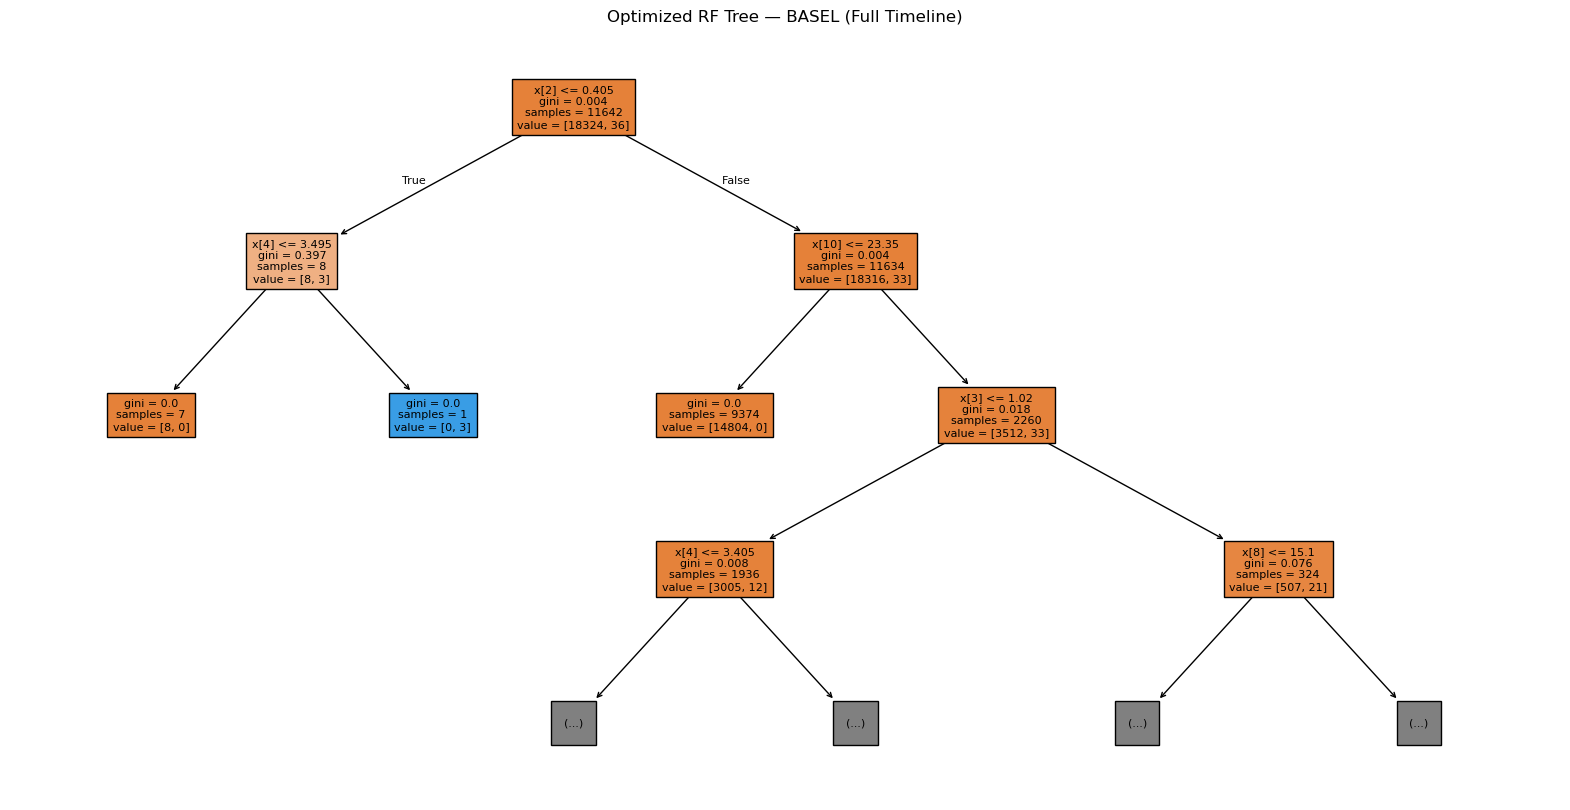

In [13]:
search_decade, best_decade = run_rf_search_and_save_tree(
    X_decade, y_decade,
    label="All Stations (Decade)",
    png_name="rf_tree_allstations_decade.png",
    n_iter=20
)

search_basel, best_basel = run_rf_search_and_save_tree(
    X_basel, y_basel,
    label="BASEL (Full Timeline)",
    png_name="rf_tree_basel_fulltimeline.png",
    n_iter=20
)


In [16]:
imp = pd.Series(best_decade.feature_importances_, index=X_decade.columns).sort_values(ascending=False)
print("Top 10 features (Decade):")
print(imp.head(10))


Top 10 features (Decade):
LJUBLJANA_pressure            0.032276
TOURS_humidity                0.030970
DEBILT_temp_max               0.027113
BUDAPEST_pressure             0.023791
STOCKHOLM_global_radiation    0.022160
KASSEL_pressure               0.020202
SONNBLICK_pressure            0.018803
TOURS_wind_speed              0.017945
VALENTIA_temp_max             0.016742
LJUBLJANA_global_radiation    0.016503
dtype: float64


In [17]:
imp_b = pd.Series(best_basel.feature_importances_, index=X_basel.columns).sort_values(ascending=False)
print("Top 10 features (BASEL):")
print(imp_b.head(10))


Top 10 features (BASEL):
BASEL_pressure            0.172336
BASEL_global_radiation    0.142830
BASEL_humidity            0.131052
BASEL_sunshine            0.125999
BASEL_temp_max            0.122333
BASEL_temp_mean           0.107843
BASEL_temp_min            0.107148
BASEL_cloud_cover         0.070997
BASEL_wind_speed          0.016273
BASEL_pleasant_weather    0.002974
dtype: float64


In [19]:
# Identify stations and variables SAFELY
stations = sorted({
    c.split("_")[0]
    for c in X_all.columns
    if "_" in c
})

variables = sorted({
    c.split("_", 1)[1]
    for c in X_all.columns
    if "_" in c
})

len(stations), len(variables)


(18, 12)

In [20]:
bad_cols = [c for c in X_all.columns if "_" not in c]
print("No-underscore columns:", bad_cols)

weird_cols = [c for c in X_all.columns if "_" in c and c.split("_",1)[0].isupper()==False]
print("Weird station prefix columns (first 20):", weird_cols[:20])


No-underscore columns: ['DATE.1']
Weird station prefix columns (first 20): []


In [21]:
station_feature_cols = [c for c in X_all.columns if "_" in c and c.split("_",1)[0].isalpha()]
print("Station-feature cols:", len(station_feature_cols))


Station-feature cols: 183


In [22]:
stations = sorted({c.split("_",1)[0] for c in station_feature_cols})
variables = sorted({c.split("_",1)[1] for c in station_feature_cols})

print("Stations:", len(stations))
print("Variables:", len(variables))


Stations: 18
Variables: 12


In [23]:
# Drop accidental duplicate column if it exists
df = df.drop(columns=["DATE.1"], errors="ignore")

# y already exists
y_all = df["pleasant"].copy()

# X_all features only
X_all = df.drop(columns=["pleasant", "DATE", "MONTH"], errors="ignore").copy()


In [24]:
# Drop accidental duplicate column if it exists
df = df.drop(columns=["DATE.1"], errors="ignore")

# y already exists
y_all = df["pleasant"].copy()

# X_all features only
X_all = df.drop(columns=["pleasant", "DATE", "MONTH"], errors="ignore").copy()


In [25]:
keep_vars = [
    "cloud_cover",
    "wind_speed",
    "humidity",
    "pressure",
    "global_radiation",
    "precipitation",
    "snow_depth",
    "sunshine",
    "temp_mean"
]


In [27]:
keep_vars = {
    "cloud_cover","wind_speed","humidity","pressure","global_radiation",
    "precipitation","snow_depth","sunshine","temp_mean"
}

station_feature_cols_9 = [
    c for c in station_feature_cols
    if c.split("_",1)[1] in keep_vars
]

stations_9 = sorted({c.split("_",1)[0] for c in station_feature_cols_9})
variables_9 = sorted({c.split("_",1)[1] for c in station_feature_cols_9})

print("Stations after var filter:", len(stations_9))
print("Variables after var filter:", len(variables_9))
print("Variables kept:", variables_9)


Stations after var filter: 18
Variables after var filter: 9
Variables kept: ['cloud_cover', 'global_radiation', 'humidity', 'precipitation', 'pressure', 'snow_depth', 'sunshine', 'temp_mean', 'wind_speed']


In [29]:
from collections import defaultdict
import numpy as np

# Build coverage map: which vars exist for each station
coverage = defaultdict(set)
for c in station_feature_cols_9:
    st, var = c.split("_", 1)
    coverage[st].add(var)

required_vars = set(variables_9)  # your 9 vars

# Keep only stations that have all 9 vars
complete_stations = sorted([st for st, vset in coverage.items() if vset == required_vars])

print("Complete stations with all 9 vars:", len(complete_stations))
print("Stations:", complete_stations)

# Pick 15 stations (first 15 is fine)
stations_final = complete_stations[:15]
print("\nUsing these 15 stations:", stations_final)

# Build X in shape (n_samples, 15, 9)
variables_final = list(variables_9)  # keep your variable order
X_cnn = np.zeros((X_all.shape[0], len(stations_final), len(variables_final)))

for i, st in enumerate(stations_final):
    for j, var in enumerate(variables_final):
        col = f"{st}_{var}"
        X_cnn[:, i, j] = X_all[col].values

y_cnn = y_all.values

print("\nX_cnn shape:", X_cnn.shape)
print("y_cnn shape:", y_cnn.shape)


Complete stations with all 9 vars: 3
Stations: ['BASEL', 'DUSSELDORF', 'OSLO']

Using these 15 stations: ['BASEL', 'DUSSELDORF', 'OSLO']

X_cnn shape: (22950, 3, 9)
y_cnn shape: (22950,)


In [31]:
from collections import defaultdict
import numpy as np

# coverage: how many of the 9 vars each station has
coverage = defaultdict(set)
for c in station_feature_cols_9:
    st, var = c.split("_", 1)
    coverage[st].add(var)

required_vars = list(variables_9)  # keep same order
all_stations = sorted(coverage.keys())

# Rank stations by how many of the 9 variables they contain (descending)
ranked = sorted(all_stations, key=lambda st: len(coverage[st]), reverse=True)

print("Top 20 stations by coverage (station, count):")
for st in ranked[:20]:
    print(st, len(coverage[st]))

# Choose the best 15 stations
stations_final = ranked[:15]
print("\nUsing these 15 stations:", stations_final)

# Build X (n_samples, 15, 9) and fill missing vars with 0
X_cnn = np.zeros((X_all.shape[0], len(stations_final), len(required_vars)))

missing_count = 0
for i, st in enumerate(stations_final):
    for j, var in enumerate(required_vars):
        col = f"{st}_{var}"
        if col in X_all.columns:
            X_cnn[:, i, j] = X_all[col].values
        else:
            missing_count += 1  # how many station-var combos were missing

y_cnn = y_all.values

print("\nMissing station-var columns filled with 0:", missing_count)
print("X_cnn shape:", X_cnn.shape)
print("y_cnn shape:", y_cnn.shape)



Top 20 stations by coverage (station, count):
BASEL 9
DUSSELDORF 9
OSLO 9
DEBILT 8
HEATHROW 8
LJUBLJANA 8
MAASTRICHT 8
MADRID 8
SONNBLICK 8
VALENTIA 8
BELGRADE 7
BUDAPEST 7
KASSEL 7
MUNCHENB 7
ROMA 6
STOCKHOLM 6
TOURS 6
GDANSK 5

Using these 15 stations: ['BASEL', 'DUSSELDORF', 'OSLO', 'DEBILT', 'HEATHROW', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'SONNBLICK', 'VALENTIA', 'BELGRADE', 'BUDAPEST', 'KASSEL', 'MUNCHENB', 'ROMA']

Missing station-var columns filled with 0: 18
X_cnn shape: (22950, 15, 9)
y_cnn shape: (22950,)


In [32]:
from sklearn.model_selection import train_test_split

# Add channel dimension for CNN
X_cnn_expanded = X_cnn[..., np.newaxis]  # (22950, 15, 9, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X_cnn_expanded,
    y_cnn,
    test_size=0.2,
    random_state=42,
    stratify=y_cnn
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (18360, 15, 9, 1)
X_test: (4590, 15, 9, 1)
y_train: (18360,)
y_test: (4590,)


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [34]:
def build_cnn(learning_rate=0.001, dropout_rate=0.3, filters=32):
    model = Sequential([
        Conv2D(filters, (3, 3), activation="relu", input_shape=(15, 9, 1)),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [38]:
from bayes_opt import BayesianOptimization

def cnn_cv(learning_rate, dropout_rate, filters):
    filters = int(filters)

    model = build_cnn(
        learning_rate=learning_rate,
        dropout_rate=dropout_rate,
        filters=filters
    )

    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    return history.history["val_accuracy"][-1]


optimizer = BayesianOptimization(
    f=cnn_cv,
    pbounds={
        "learning_rate": (0.0001, 0.01),
        "dropout_rate": (0.2, 0.5),
        "filters": (16, 64)
    },
    random_state=42,
)

optimizer.maximize(init_points=3, n_iter=5)


|   iter    |  target   | learni... | dropou... |  filters  |
-------------------------------------------------------------


C:\Users\ducat\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 1         | 0.9983659 | 0.0038079 | 0.4852142 | 51.135709 |
| 2         | 0.9983659 | 0.0060267 | 0.2468055 | 23.487736 |
| 3         | 0.9983659 | 0.0006750 | 0.4598528 | 44.853520 |


C:\Users\ducat\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 4         | 0.9983659 | 0.0062963 | 0.4137401 | 63.995290 |


C:\Users\ducat\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 5         | 0.9983659 | 0.0059318 | 0.2938531 | 16.000358 |


C:\Users\ducat\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 6         | 0.9983659 | 0.0024443 | 0.3221183 | 34.265314 |


C:\Users\ducat\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 7         | 0.9983659 | 0.0082652 | 0.2732782 | 63.993402 |


C:\Users\ducat\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 8         | 0.9983659 | 0.0063881 | 0.3833662 | 16.000756 |


In [39]:
!pip install -q bayesian-optimization


In [40]:
from bayes_opt import BayesianOptimization


In [41]:
best_params = optimizer.max["params"]
best_params["filters"] = int(best_params["filters"])

print("Best CNN parameters:", best_params)

final_model = build_cnn(
    learning_rate=best_params["learning_rate"],
    dropout_rate=best_params["dropout_rate"],
    filters=best_params["filters"]
)

history = final_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print("Final CNN Test Accuracy:", test_acc)


Best CNN parameters: {'learning_rate': np.float64(0.003807947176588889), 'dropout_rate': np.float64(0.4852142919229748), 'filters': 51}
Epoch 1/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9960 - loss: 0.0256 - val_accuracy: 0.9984 - val_loss: 0.0087
Epoch 2/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9980 - loss: 0.0132 - val_accuracy: 0.9984 - val_loss: 0.0133
Epoch 3/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9980 - loss: 0.0125 - val_accuracy: 0.9984 - val_loss: 0.0080
Epoch 4/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9980 - loss: 0.0112 - val_accuracy: 0.9984 - val_loss: 0.0076
Epoch 5/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9980 - loss: 0.0103 - val_accuracy: 0.9984 - val_loss: 0.0097
Epoch 6/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9980 - loss: 0.0100 - val_accuracy: 0.9984 - val_loss: 0.0102
Epoch 7/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9980 - loss: 0.0112 - val_accu

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   


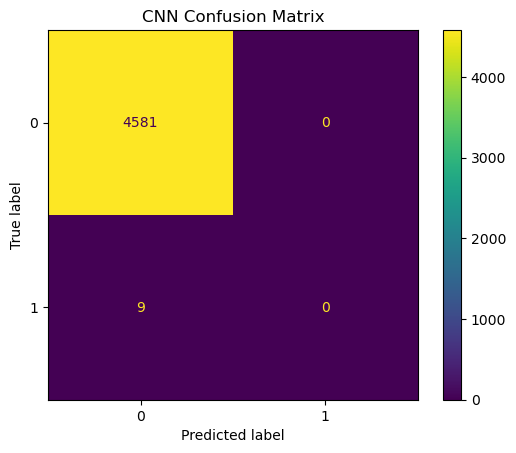

Confusion Matrix:
 [[4581    0]
 [   9    0]]


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (final_model.predict(X_test) > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("CNN Confusion Matrix")
plt.show()

print("Confusion Matrix:\n", cm)


In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9980    1.0000    0.9990      4581
           1     0.0000    0.0000    0.0000         9

    accuracy                         0.9980      4590
   macro avg     0.4990    0.5000    0.4995      4590
weighted avg     0.9961    0.9980    0.9971      4590



C:\Users\ducat\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ducat\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ducat\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weight)

final_model = build_cnn(
    learning_rate=best_params["learning_rate"],
    dropout_rate=best_params["dropout_rate"],
    filters=best_params["filters"]
)

history = final_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    class_weight=class_weight
)

test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print("Weighted CNN Test Accuracy:", test_acc)


Class weights: {0: np.float64(0.5009823182711198), 1: np.float64(255.0)}
Epoch 1/10


C:\Users\ducat\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7102 - loss: 2.3792 - val_accuracy: 0.9818 - val_loss: 0.2074
Epoch 2/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7653 - loss: 0.4974 - val_accuracy: 0.7211 - val_loss: 0.5164
Epoch 3/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7952 - loss: 0.4194 - val_accuracy: 0.2955 - val_loss: 0.9584
Epoch 4/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7002 - loss: 0.6822 - val_accuracy: 0.3562 - val_loss: 0.9668
Epoch 5/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6998 - loss: 1.6872 - val_accuracy: 0.6492 - val_loss: 0.8072
Epoch 6/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7917 - loss: 1.0333 - val_accuracy: 0.6950 - val_loss: 0.5750
Epoch 7/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8028 - loss: 1.0306 - val_accuracy: 0.9981 - val_loss: 0.0095
Epoch 8/10
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7835 - loss: 1.1393 - val_accuracy: 0.7710 - val_

In [45]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# predicted probabilities for class 1
probs = final_model.predict(X_test).ravel()

for thresh in [0.5, 0.3, 0.2, 0.1]:
    y_pred_t = (probs >= thresh).astype(int)
    print("\n" + "="*60)
    print(f"Threshold: {thresh}")
    print(confusion_matrix(y_test, y_pred_t))
    print(classification_report(y_test, y_pred_t, digits=4, zero_division=0))


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   

Threshold: 0.5
[[2071 2510]
 [   0    9]]
              precision    recall  f1-score   support

           0     1.0000    0.4521    0.6227      4581
           1     0.0036    1.0000    0.0071         9

    accuracy                         0.4532      4590
   macro avg     0.5018    0.7260    0.3149      4590
weighted avg     0.9980    0.4532    0.6215      4590


Threshold: 0.3
[[1944 2637]
 [   0    9]]
              precision    recall  f1-score   support

           0     1.0000    0.4244    0.5959      4581
           1     0.0034    1.0000    0.0068         9

    accuracy                         0.4255      4590
   macro avg     0.5017    0.7122    0.3013      4590
weighted avg     0.9980    0.4255    0.5947      4590


Threshold: 0.2
[[1869 2712]
 [   0    9]]
              precision    recall  f1-score   support

           0     1.0000    0.4080    0.5795      4581
           1     0.0033    1.0000    0.0066         9

    accur

In [46]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, probs)
print("ROC-AUC:", auc)


ROC-AUC: 0.9823667806640957


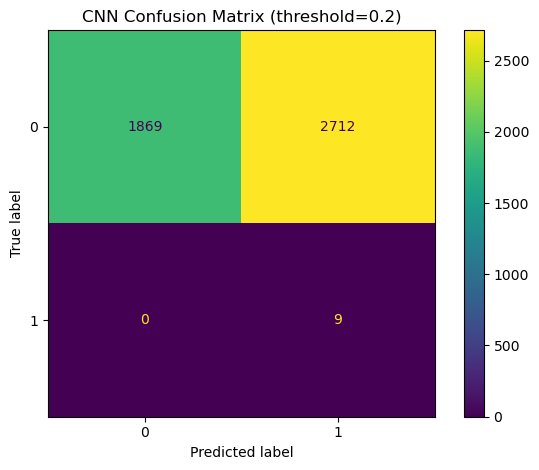

Saved: cnn_confusion_matrix.png
Confusion matrix:
 [[1869 2712]
 [   0    9]]


In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

thresh = 0.2  # or whichever threshold worked best above
y_pred = (probs >= thresh).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"CNN Confusion Matrix (threshold={thresh})")
plt.tight_layout()
plt.savefig("cnn_confusion_matrix.png", dpi=200)
plt.show()

print("Saved: cnn_confusion_matrix.png")
print("Confusion matrix:\n", cm)
